Importing the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

Using TensorFlow backend.


## Preprocessing
Loading the MNIST dataset and performing the required preprocessing on the data. Reshaping the training data and testing data such that all the images are flattened into column and each column of the dataset X represents one training example. Additionally, normalizing the training and testing data by dividing each pixel value in the dataset by 255.  Reshaping the training and testing label to a row vector. The last digit of my student ID = 0, thus modifying the labels of the training and testing data to contain value 1 for an image containing the number 0 and a value of 0 otherwise. Additionally, printing the shapes of the training and testing data and labels to confirm correct preprocessing.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('The training set contains: ', len(x_train))
print('test set: ', len(x_test))
print('Shape of the training data',x_train.shape)
print('shape of training label',y_train.shape)
# Performing the preprocessing steps on the data set
# Reshaping the training and test set such that each column represents an image
# Reshaping the training and test labels into row vectors
x_train = np.reshape(x_train, (60000, -1))
x_train = x_train.T
y_train = np.reshape(y_train, (1, -1))
x_test = np.reshape(x_test, (10000, -1))
x_test = x_test.T
y_test = np.reshape(y_test, (1, -1))
# Normalizing the data in training and test sets
x_train = x_train/255
x_test = x_test/255
# Updating the labels in the training and test set
# Last digit of my student id = 0
# Thus, the label of an image of number 0 should be 1 and 0 otherwise
# This is achieved by creating masks for the training and testing labels such that the masks have True for indices
# which correspond to an image of number 0
id_mask_train = y_train == 0
id_mask_test = y_test == 0
y_train[id_mask_train] = 1
y_train[np.logical_not(id_mask_train)] = 0
y_test[id_mask_test] = 1
y_test[np.logical_not(id_mask_test)] = 0
# Checking the shape of the training and test sets
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

The training set contains:  60000
test set:  10000
Shape of the training data (60000, 28, 28)
shape of training label (60000,)
(784, 60000)
(784, 10000)
(1, 60000)
(1, 10000)


## Activation Functions and their Gradients
Functions for implementing the sigmoid activation, tanh activation and ReLU activation functions. The function act_gradient computes and returns the gradeint of the activation function (provided as parameter). 

In [3]:
def act_sigmoid(z):
    A = 1/(1+np.exp(-z))
    return A


def act_tanh(z):
    A = np.tanh(z)
    return A


def act_relu(z):
    A = np.maximum(0, z)
    return A


def act_gradient(A, act = 'ReLU'):
    dg = np.zeros_like(A)
    if act == 'ReLU':
        dg[A>0] = 1
    elif act == 'sigmoid':
        dg = A*(1 - A)
    elif act == 'tanh':
        dg = 1 - np.square(A)
    
    return dg

## Neural Network Class
Class for creating and training the neural network with 1 hidden layer to solve the Binary Classification problem on the MNIST dataset. The constructor method (_init_) loads the training and the test dataset, splits the training set into training (48000) + validation set(12000). The validation set is later used to tune the hyperparameters like the learning rate, the number of neurons in the hidden layer, the activation function for the hidden layer etc. It also initializes the weights and biases for the two layers small random values of the required dimensions using the numpy method random.random(). The random values (between 0 and 1) are multiplied by 0.01 to make them small. The number of neurons and the activation function for the hidden layer of the network is also loaded in the constructor method.



### Forward Propagation
The method forwardProp() performs the forward propagation through one layer of the neural network. The parameters provided to the method are : the weights and the biases associated with the layer, input to the layer and the activation function of the layer. It returns the output form the layer. 

### Gradient Descent
The method GradDescent() implements the gradient descent algorithm for learning the weights and the biases for the layers of the Neural Network. After testing various values for epochs using the validation set, I decided with 1000 iterations for the gradient descent. While increasing the number of epochs decreased the training error (not by much, though), it resulted in an increased value of the validation error.
The method takes as input the learning rate and a boolean value for plotting the learning curve, and returns the learned values of the weights and biases for all layers.

### Train Model
The method train_model() performs the gradeint descent algorithm for the training dataset, performs the forward propagation with the learned parameters to generate the predicted values for training set and computes the cost and accuracy achieved by the trained model on the training data. If multiple learning rates are provided to the object, then train_model() performs training with each learning rate, computes the cost of the learned model on the validation set and selects the value of alpha which performs best on the validation set for the final training of the model. The accuracy is computed by rounding the predicted values upto 1 decimal place. Thus, only predicted values greater than 0.9 are rounded to 1 and less than 0.1 are rounded to 0, thus giving much better assessment of the model than just using the np.around() method. These rounded prediction values are compared with ground truth values to comput the accuracy on the training data.

### Test Model
The method test_model assess the trained model on the test data set. It performs the forward propagation with the learned parameters to generate the predicted values for the test set and computes the cost and accuracy achieved by the trained model on the test dataset. The accuracy is computed by rounding the predicted values upto 1 decimal place. Thus, only predicted values greater than 0.9 are rounded to 1 and less than 0.1 are rounded to 0, thus giving much better assessment of the model than just using the np.around() method. These rounded prediction values are compared with ground truth values to comput the accuracy on the test data.

### Test Image
The method test_image() assess the trained model on a single test image with index of the image in the test dataset provided as parameter. The function displays the ground truth value and the actual value predicted by the model.


In [4]:
class NeuralNetwork:
    def __init__(self, x_train, y_train, x_test, y_test, alpha, neurons = 5, activation = 'ReLU'):
        self.x_train = x_train[:, :48000]
        self.y_train = y_train[:, :48000]
        self.x_test = x_test
        self.y_test = y_test
        self.alpha = alpha
        self.x_val = x_train[:, 48000:]
        self.y_val = y_train[:, 48000:]
        self.m = self.x_train.shape[1]
        self.neurons = neurons
        self.activation = activation
        
        # Initializing the weights and biases using np.random.random() and multiplying them by 0.01 to initialize small values.
        self.w1 = np.random.random((self.neurons, x_train.shape[0])) * 0.01
        self.b1 = np.random.random((self.neurons, 1)) * 0.01
        self.w2 = np.random.random((1, self.neurons)) * 0.01
        self.b2 = np.random.random() * 0.01
        
        
    def forwardProp(self, w, x, b, act = 'ReLU'):
        # performs the forward propagation through one layer of the neural network
        Z = np.dot(w, x) + b
        if act == 'ReLU':
            A = act_relu(Z)
        elif act == 'tanh':
            A = act_tanh(Z)
        elif act == 'sigmoid':
            A = act_sigmoid(Z)
        return Z, A
    
    def GradDescent(self, a, pl = False):
        w1 = np.copy(self.w1)
        w2 = np.copy(self.w2)
        b1 = np.copy(self.b1)
        b2 = np.copy(self.b2)

        for i in range(1000):

            Z1, A1 = self.forwardProp(w1, self.x_train, b1, self.activation)
            Z2, A2 = self.forwardProp(w2, A1, b2, 'sigmoid')
            cost = - np.sum(self.y_train*np.log(A2) + (1 - self.y_train)*np.log(1 - A2))/self.m
            dZ2 = A2 - self.y_train
            dw2 = np.dot(dZ2, A1.T)/self.m
            db2 = np.sum(dZ2)/self.m

            dZ1 = np.dot(w2.T, dZ2)*act_gradient(A1, self.activation)
            dw1 = np.dot(dZ1, self.x_train.T)/self.m
            db1 = np.sum(dZ1)/self.m
            if pl:
                plt.plot(i, cost, 'bo')
                plt.title('Learning Curve')
                plt.xlabel('Iterations')
                plt.ylabel('Cost')
            w1 -= a*dw1
            w2 -= a*dw2
            b1 -= a*db1
            b2 -= a*db2
        return w1, b1, w2, b2
    
    def train_model(self):
        # Checking to see if a single value of alpha is provided or if multiple values are provided. 
        # If multiple values are provided then the best learning rate is selected by cross validation
        if len(self.alpha)>1:
            # To hold the cost of models learned by various alpha values
            cost_val = []
            # To hold weights and biases for different learning rates
            parameters = []
            print('Performing Validation to tune Hyper-parameters')
            # Looping over all the learning rates to determine the best one
            for a in self.alpha:
                # Performing gradient descent to update the weights and bias of the model. 
                w1, b1, w2, b2 = self.GradDescent(a)
                # Performing forward propagation
                Z1_t, A1_t = self.forwardProp(w1, self.x_train, b1, self.activation)
                Z2_t, A2_t = self.forwardProp(w2, A1_t, b2, 'sigmoid')
                
                # Computing the vectorized cost function
                cost = - np.sum(self.y_train*np.log(A2_t) + (1 - self.y_train)*np.log(1 - A2_t))/self.m
                print('For alpha = ', a, 'cost on training = ', cost)
                
                # Forward propagation for validation dataset
                Z1_v, A1_v = self.forwardProp(w1, self.x_val, b1, self.activation)
                Z2_v, A2_v = self.forwardProp(w2, A1_v, b2, 'sigmoid')
                # Computing cost over the validation set
                cost_v = - np.sum(self.y_val*np.log(A2_v) + (1 - self.y_val)*np.log(1 - A2_v))/self.x_val.shape[1]
                print('For alpha = ', a, 'cost on validation=', cost_v)
                # Appending the cost to the list containing cost for different alpha values on the validation set
                cost_val.append(cost_v)
                # Appending the parameters for different alpha values
                parameters.append((w1, b1, w2, b2))
            # Selecting the alpha value with the minimum cost on the validation set
            alpha = self.alpha[np.argmin(cost_val)]
            print('Best value of alpha = ', alpha)
            
#             w1, b1, w2, b2 = parameters[np.argmin(cost_val)]            
#             Z1_t, A1_t = self.forwardProp(w1, self.x_train, b1, self.activation)
#             Z2_t, A2_t = self.forwardProp(w2, A1_t, b2, 'sigmoid')
#             cost = - np.sum(self.y_train*np.log(A2_t) + (1 - self.y_train)*np.log(1 - A2_t))/self.m
#             print('The training error = ', cost)
            
        else:
            alpha = self.alpha[0]
        print('Performing the final training')
        # Training the model using best alpha value
        fw1, fb1, fw2, fb2 = self.GradDescent(alpha, pl = True)
        Z_train1, A_train1 = self.forwardProp(fw1, self.x_train, fb1, self.activation)
        Z_train2, A_train2 = self.forwardProp(fw2, A_train1, fb2, 'sigmoid')
        # Rounding the predicted value upto 1 decimal place
        A_2t = np.around(A_train2, 1)
        # Computing the accuracy over the training
        accuracy = np.mean(A_2t == self.y_train)
        print('Training accuracy = ', accuracy)
        # Computing the training cost
        cost_train = - np.sum(self.y_train * np.log(A_train2) + (1 - self.y_train)*np.log(1 - A_train2))/self.m
        print('Final Training cost = ', cost_train)

        # Saving the learned weights
        self.w1 = fw1
        self.b1 = fb1
        self.w2 = fw2
        self.b2 = fb2
    
    def test_model(self):
        # Forward propagation on the test data
        Z1_test, A1_test = self.forwardProp(self.w1, self.x_test, self.b1, self.activation)
        Z2_test, A2_test = self.forwardProp(self.w2, A1_test, self.b2, 'sigmoid')
        # Computing the cost on test set
        cost_test = - np.sum(self.y_test*np.log(A2_test) + (1 - self.y_test)*np.log(1 - A2_test))/self.x_test.shape[1]
        print('Testing Cost = ', cost_test)
        # Computing the accuracy on test data
        A2 = np.around(A2_test, 1)
        accuracy = np.mean(A2 == self.y_test)
        print('Test accuracy = ', accuracy)
    
    def test_image(self, i):
        # Performing prediction on ith image in the test set
        x = self.x_test[:, i]
        # Reshaping to column vector
        x = np.reshape(x, (-1, 1))
        # getting the ground truth label
        y = self.y_test[0, i]
        # Forward propagation
        Z1, A1 = self.forwardProp(self.w1, x, self.b1, self.activation)
        Z2, A2 = self.forwardProp(self.w2, A1, self.b2, 'sigmoid')
        # Print the results and displaying the image
        print('Ground truth for test example {} = {}'.format(i, y))
        print('Predicted Output for test example {} = {}'.format(i, A2))
        plt.imshow(np.reshape(x, (28, 28)), 'gray')
        plt.title('Test Example {}'.format(i))

## Implementation
Creating the object of the class Neural Network. 
After evaluating the model on the vallidation set with different values of the hyperparameters, I found the following values to give the best performance:
learning rate - 1.1. After comparing with values including 2, 1.5, 1.2, 1.1, 1, 0.9, 0.5, 0.2, 0.1. 
Activation function for hidden layer - tanh. Compared with ReLU, tanh resulted in low cost values in most scenarios with validation set.
Number of Neurons per hidden layer - 8. This number provided the best performance on the validation set

The training cost achieved = 0.012081 (this can vary a little with each execution)
The training accuracy achieved = 97.49375% (only predicted values greater than 0.9 are rounded to 1 and less than 0.1 are rounded to 0)
The test cost achieved = 0.015566329
The test accuracy achieved = 97.5%

Training Mode
Performing the final training
Training accuracy =  0.9746666666666667
Final Training cost =  0.012304347485987674
Testing Mode
Testing Cost =  0.015875617596939905
Test accuracy =  0.9751


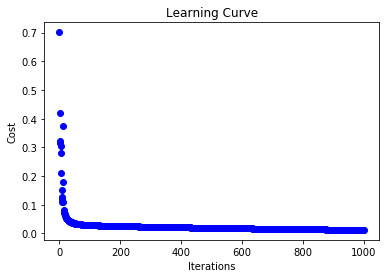

In [10]:
# alpha = [1.2, 1.1, 1, 0.5]
# Setting the learning rate and the activation function for the hidden layer
alpha = [1.1]
activation = 'tanh'
# neurons = [5, 6, 7, 8, 9, 10]
# for i in neurons:
#     print('No. of neurons = ', i)
#     LR = LogisticRegression(x_train, y_train, x_test, y_test, alpha, neurons = i)
#     print('Training Mode')
#     LR.train_model()

# Setting the number of neurons in the hidden layer 
neurons = 8
# Creating instance of the neural network class
LR = NeuralNetwork(x_train, y_train, x_test, y_test, alpha, neurons = neurons, activation = activation)
print('Training Mode')
LR.train_model()
print('Testing Mode')
LR.test_model()



Testing the model on single test images

Ground truth for test example 78 = 0
Predicted Output for test example 78 = [[1.59040588e-05]]


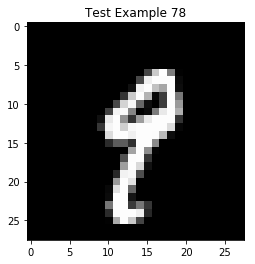

In [32]:
LR.test_image(78)

Ground truth for test example 3 = 1
Predicted Output for test example 3 = [[0.99033583]]


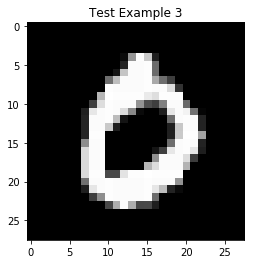

In [33]:
LR.test_image(3)